# Anomaly detection-risk based clustering classification, recall/precesion optimization with stacking models
<img src = 'https://images.unsplash.com/photo-1536390069759-2db770b49d77?ixid=MnwxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8&ixlib=rb-1.2.1&auto=format&fit=crop&w=1500&q=80' width="800" height="133">

In [176]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
# Imports
import pandas as pd
import numpy as np
import seaborn as sns; sns.set()
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['font.family']='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  #한글 폰트 사용시 마이너스 폰트 깨짐 해결

In [177]:
def summary(df) :
    tf = pd.DataFrame({'데이터형태(dtypes)' : df.dtypes,
                       '결측치 수(null)' : df.isnull().sum(),
                       '결측치 비율(%)' : (df.isnull().sum()/len(df)).round(2),
                       '고유값 수(nunique)' : df.nunique(),
                      })
    for col in tf.index:
        tf.loc[col, '자료 내용(contents)'] = str(df[col].unique()[0:5])
        tf.loc[col, 'nan 비율'] = int(df[df[col] == 'nan'].shape[0]/len(df)*100)
        
    return tf

In [179]:
df = pd.read_pickle('../../pkl/df_filtered-01.pkl')
df

,품목명,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1,서류가공품,판매용,캐나다,1.238,아니오,아니오,아니오,해당없음,N,N,N,0,9.875088,10.088854
2,청주,판매용,일본,3.636,아니오,아니오,아니오,해당없음,N,N,N,0,10.162770,11.453674
3,소스류,판매용,중국,2.004,아니오,아니오,아니오,표시하지않음,N,N,N,0,7.321189,8.016318
4,과실주,판매용,프랑스,5.733,아니오,아니오,아니오,해당없음,N,N,N,0,5.192957,6.939254
5,만두류,판매용,중국,4.540,아니오,아니오,아니오,해당없음,N,N,N,0,7.677864,9.190852
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
714384,과실주,판매용,뉴질랜드,9.600,아니오,아니오,아니오,해당없음,N,N,N,0,7.832014,10.093777
714387,초콜릿가공품,판매용,일본,5.000,아니오,아니오,아니오,표시함,N,N,N,0,4.248495,5.857933
714390,과실주,판매용,프랑스,30.000,아니오,아니오,아니오,해당없음,N,N,N,0,4.682131,8.083329
714395,기타 농산가공품,판매용,미국,53.010,아니오,아니오,아니오,해당없음,N,N,N,0,5.298317,9.268798


In [180]:
df.rename(columns = {'품목명' : '유형'}, inplace = True)

# 1. 데이터 전처리 
- 데이터전처리와 교차검증 분리
- SMOTE()적용을 위해 모든 특성변수는 수치화

## Data Visualization

<AxesSubplot:>

Text(0.5, 1.0, '가공식품 제품유형별 수입신고 빈도(상위 50개 유형)')

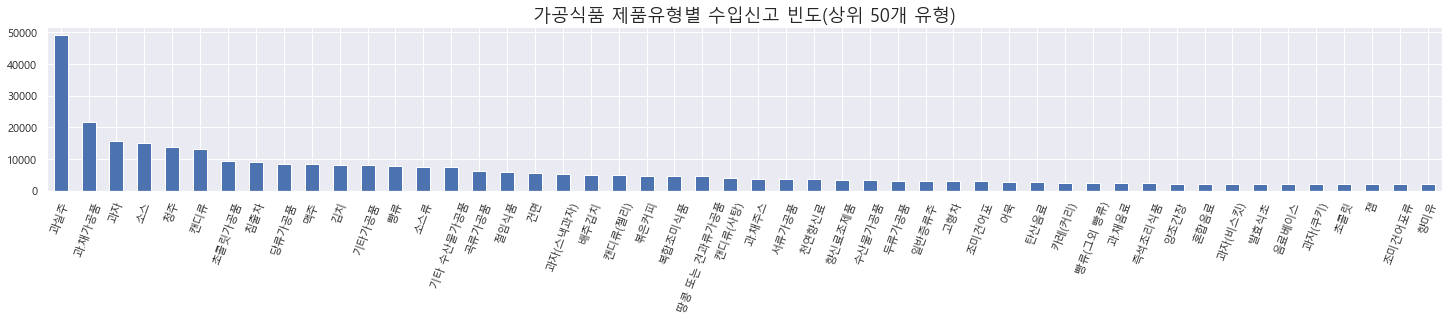

<AxesSubplot:>

Text(0.5, 1.0, '가공식품 제조국(원산지)별 수입신고 빈도(상위 50개국)')

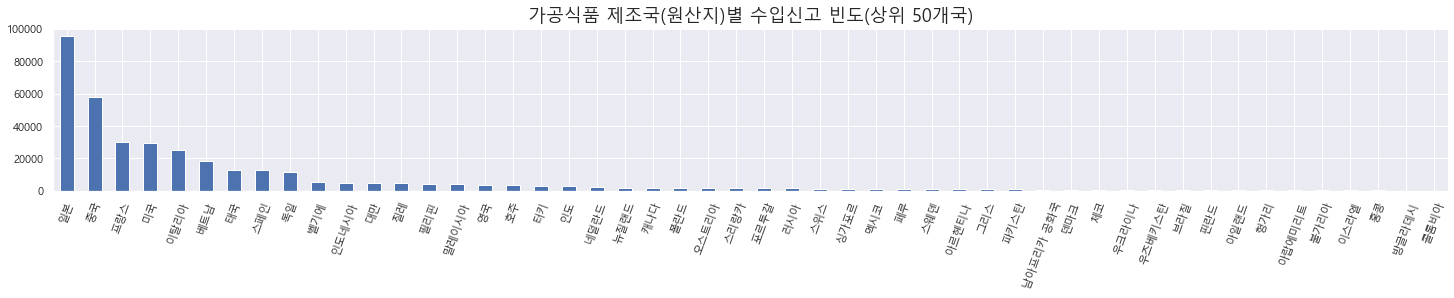

In [181]:
df.유형.value_counts().nlargest(50).plot(kind='bar', figsize=(25, 3), rot=70)
plt.title('가공식품 제품유형별 수입신고 빈도(상위 50개 유형)', fontsize=18); plt.show()
df['제조국(원산지)'].value_counts().nlargest(50).plot(kind='bar', figsize=(25, 3), rot=70)
plt.title('가공식품 제조국(원산지)별 수입신고 빈도(상위 50개국)', fontsize=18)

In [182]:
df[df['제조국(원산지)'] == '가나']

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
249775,수산물가공품,판매용,가나,5.182,아니오,아니오,예,해당없음,N,Y,N,0,8.946375,10.591622
622306,서류가공품,판매용,가나,0.480,아니오,아니오,아니오,해당없음,N,N,N,0,6.109248,5.375278
627590,기타 수산물가공품,판매용,가나,0.600,아니오,아니오,아니오,해당없음,N,N,N,1,3.912023,3.401197
630877,과.채가공품,판매용,가나,1.500,아니오,아니오,아니오,해당없음,N,N,N,0,4.941642,5.347108
633268,서류가공품,판매용,가나,1.029,아니오,아니오,아니오,해당없음,N,N,N,1,6.368187,6.396930
633331,서류가공품,판매용,가나,0.480,아니오,아니오,아니오,해당없음,N,N,N,0,6.109248,5.375278
633583,과.채가공품,판매용,가나,2.000,아니오,아니오,아니오,해당없음,N,N,N,0,3.912023,4.605170
642163,서류가공품,판매용,가나,0.577,아니오,아니오,아니오,해당없음,N,N,N,1,6.476972,5.926926
645898,과.채가공품,판매용,가나,1.042,아니오,아니오,아니오,해당없음,N,N,N,0,5.257495,5.298317
648118,기타가공품,판매용,가나,1.000,아니오,아니오,아니오,해당없음,N,N,N,0,2.995732,2.995732


In [183]:
df.groupby('제조국(원산지)')['판정결과'].mean()

제조국(원산지)
가나           0.312500
그리스          0.010274
남아프리카 공화국    0.009650
네덜란드         0.011101
네팔           0.048387
               ...   
핀란드          0.008108
필리핀          0.022057
헝가리          0.009524
호주           0.014319
홍콩           0.078261
Name: 판정결과, Length: 84, dtype: float64

In [184]:
df.groupby('유형')['판정결과'].mean().fillna(0).reset_index().sort_values('판정결과', ascending=False)

,유형,판정결과
150,합성식초,1.000000
163,효소분해간장,1.000000
35,기타동물성유지,0.500000
13,과.채류효소함유제품,0.500000
97,압착고추씨기름,0.250000
...,...,...
76,볶은커피,0.001273
22,과자(크래커),0.001072
138,카레(커리),0.000812
158,혼합장,0.000762


Text(0.5, 1.0, '제품유형의 수입 단가별 적합 부적합 상자그림')

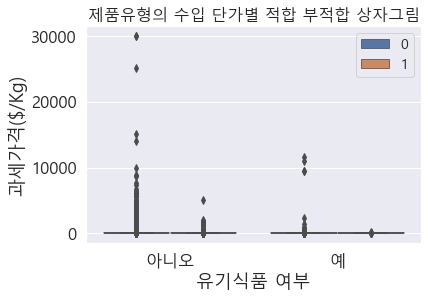

In [185]:
#plt.figure(figsize=(30,15))
sns.set(font_scale = 1.5)
plt.rcParams['font.family']='Malgun Gothic'
ax = sns.boxplot(x ='유기식품 여부', y = "과세가격($/Kg)",  hue = "판정결과",  data = df) # palette = "Set3",
ax.legend(loc='best', fontsize=14)
ax.set_title('제품유형의 수입 단가별 적합 부적합 상자그림', fontsize=16)

## Data preparation

In [186]:
tf = df.copy()

In [187]:
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

numeric_features = tf.drop(['판정결과'], axis=1).select_dtypes(include=['int64', 'float64']).columns
categorical_features = tf.drop(['판정결과'], axis=1).select_dtypes(include=['object', 'category']).columns
numeric_features
categorical_features

Index(['과세가격($/Kg)', '순중량(Kg)_log', '과세가격_log'], dtype='object')

Index(['유형', '용도명', '제조국(원산지)', '유기식품 여부', '영유아섭취대상', '주문자상표부착', '유전자변형식품',
       '가온보존대상', '진균수시험대상', '방사선조사식품'],
      dtype='object')

### 범주형 변수의 target mean

In [188]:
import category_encoders as ce
encoder = ce.target_encoder.TargetEncoder(cols= categorical_features)
encoder.fit(tf[categorical_features], tf['판정결과'])
tf[categorical_features] = encoder.transform(tf[categorical_features])
tf.head()
tf.shape

TargetEncoder(cols=Index(['유형', '용도명', '제조국(원산지)', '유기식품 여부', '영유아섭취대상', '주문자상표부착', '유전자변형식품',
       '가온보존대상', '진균수시험대상', '방사선조사식품'],
      dtype='object'))

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1,0.010219,0.01083,0.011564,1.238,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,9.875088,10.088854
2,0.000145,0.01083,0.000867,3.636,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,10.162770,11.453674
3,0.009700,0.01083,0.014806,2.004,0.010792,0.010825,0.010919,0.006059,0.010785,0.010653,0.01071,0,7.321189,8.016318
4,0.001284,0.01083,0.003169,5.733,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,5.192957,6.939254
5,0.006593,0.01083,0.014806,4.540,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,7.677864,9.190852


(366385, 14)

array([[<AxesSubplot:title={'center':'유형'}>,
        <AxesSubplot:title={'center':'용도명'}>,
        <AxesSubplot:title={'center':'제조국(원산지)'}>],
       [<AxesSubplot:title={'center':'유기식품 여부'}>,
        <AxesSubplot:title={'center':'영유아섭취대상'}>,
        <AxesSubplot:title={'center':'주문자상표부착'}>],
       [<AxesSubplot:title={'center':'유전자변형식품'}>,
        <AxesSubplot:title={'center':'가온보존대상'}>,
        <AxesSubplot:title={'center':'진균수시험대상'}>],
       [<AxesSubplot:title={'center':'방사선조사식품'}>, <AxesSubplot:>,
        <AxesSubplot:>]], dtype=object)

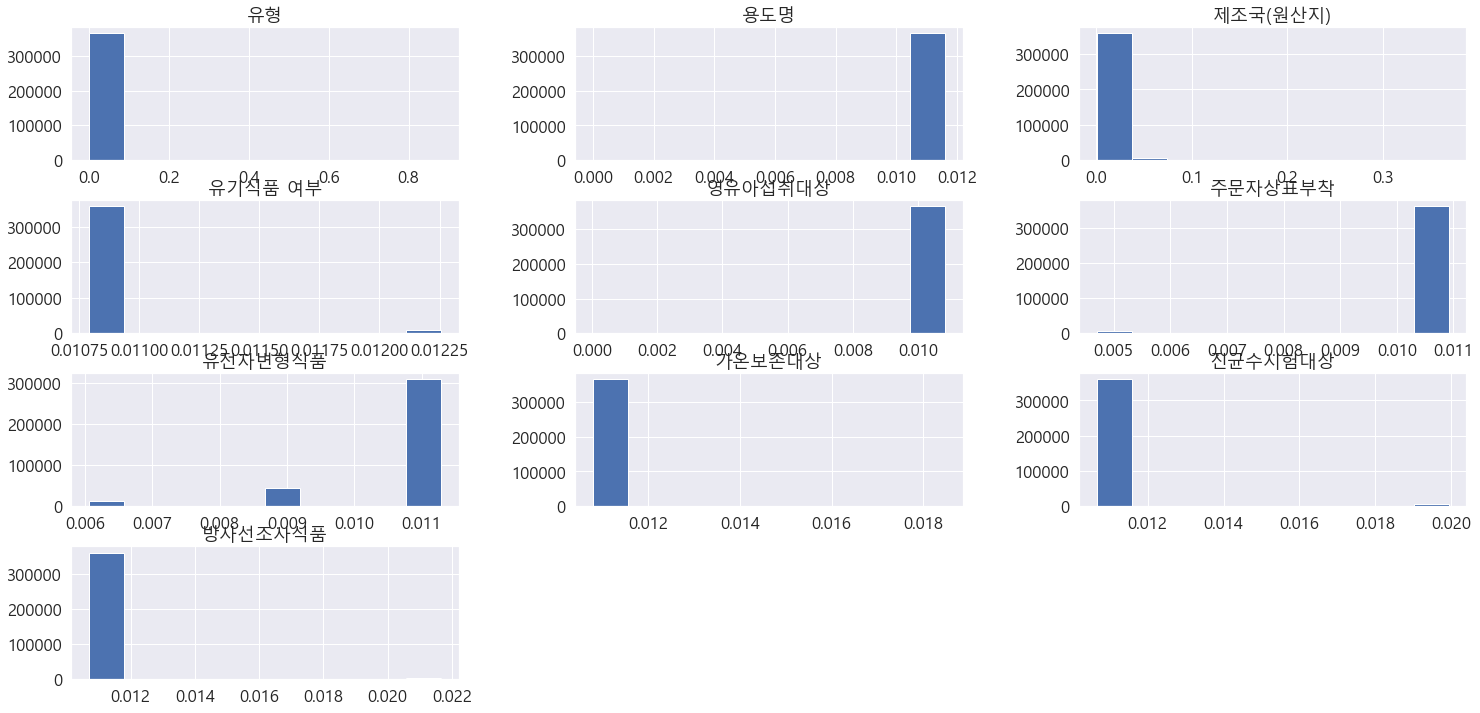

In [189]:
tf[categorical_features].hist(figsize=(25,12))

### 실수형 변수의 표준화(dynamic time warping을 적용하기 위해 minmax로 모든 변수를 0 ~ 1로 표준화)

In [190]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
encoder = MinMaxScaler()
encoder.fit(tf[numeric_features], tf['판정결과'])
tf[numeric_features] = encoder.transform(tf[numeric_features])
#tf[numeric_features].mean(); tf[numeric_features].std()
tf[numeric_features].min(); tf[numeric_features].max()
tf.head()
tf.shape

MinMaxScaler()

과세가격($/Kg)     0.0
순중량(Kg)_log    0.0
과세가격_log       0.0
dtype: float64

과세가격($/Kg)     1.0
순중량(Kg)_log    1.0
과세가격_log       1.0
dtype: float64

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1,0.010219,0.01083,0.011564,0.000041,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,0.855418,0.732446
2,0.000145,0.01083,0.000867,0.000121,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,0.881669,0.818602
3,0.009700,0.01083,0.014806,0.000067,0.010792,0.010825,0.010919,0.006059,0.010785,0.010653,0.01071,0,0.622371,0.601616
4,0.001284,0.01083,0.003169,0.000191,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,0.428168,0.533626
5,0.006593,0.01083,0.014806,0.000151,0.010792,0.010825,0.010919,0.011295,0.010785,0.010653,0.01071,0,0.654919,0.675759


(366385, 14)

array([[<AxesSubplot:title={'center':'과세가격($/Kg)'}>,
        <AxesSubplot:title={'center':'순중량(Kg)_log'}>],
       [<AxesSubplot:title={'center':'과세가격_log'}>, <AxesSubplot:>]],
      dtype=object)

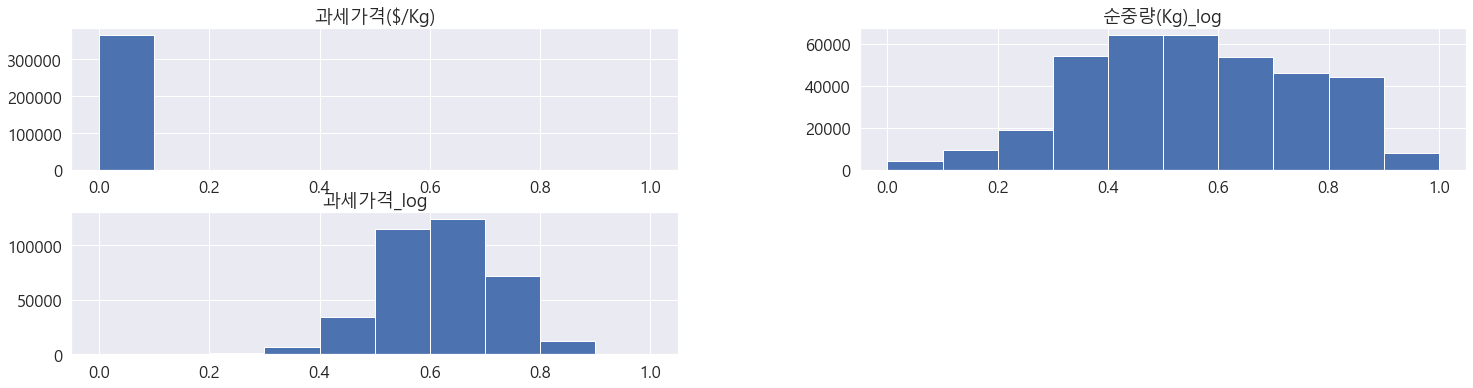

In [191]:
tf[numeric_features].hist(figsize=(25,6))

- Target 수치화

In [192]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
label_encoder = le.fit(tf['판정결과'])
tf['판정결과'] = label_encoder.transform(tf['판정결과'])
tf.columns

Index(['유형', '용도명', '제조국(원산지)', '과세가격($/Kg)', '유기식품 여부', '영유아섭취대상', '주문자상표부착',
       '유전자변형식품', '가온보존대상', '진균수시험대상', '방사선조사식품', '판정결과', '순중량(Kg)_log',
       '과세가격_log'],
      dtype='object')

# 3. Anomaly detection 

In [193]:
X = tf.drop('판정결과', axis=1)
X.shape
y = tf['판정결과']

data =  tf[['순중량(Kg)_log', '과세가격_log', '판정결과']]
data.columns = ['weight', 'price', 'y_true']

data.y_true.value_counts()
data.y_true.value_counts(normalize=True)*100

(366385, 13)

0    362419
1      3966
Name: y_true, dtype: int64

0    98.917532
1     1.082468
Name: y_true, dtype: float64

## 3.1. NearestNeighbors(n_neighbors = 3)

NearestNeighbors(n_neighbors=3)

<AxesSubplot:>

Text(0.5, 1.0, 'Distance mean of KNN')

Text(0.5, 0, 'Instances')

Text(0, 0.5, 'Mean of Distance')

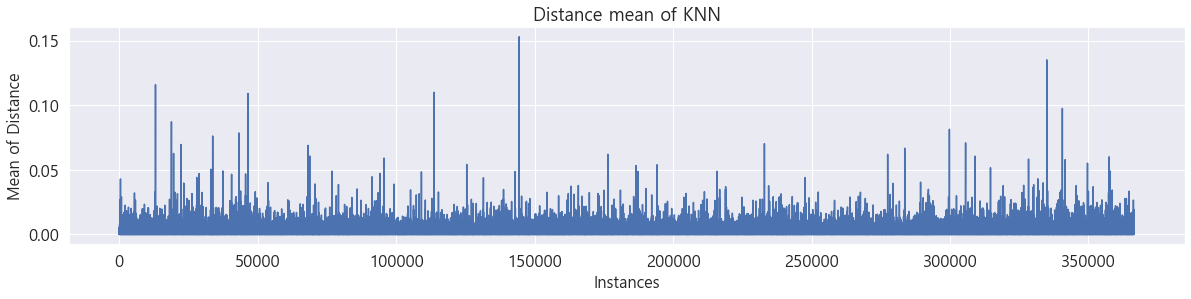

In [194]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors = 3) #algorithm='ball_tree'
nbrs.fit(X)
distances, indices = nbrs.kneighbors(X) # distances : distances between data points
                                           # indices : associated index values
pd.Series(distances.mean(axis =1)).plot(figsize=(20,4))
plt.title('Distance mean of KNN', fontsize = 18)
plt.xlabel('Instances', fontsize = 16); plt.ylabel('Mean of Distance', fontsize = 16)

In [195]:
nbrs.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 3,
 'p': 2,
 'radius': 1.0}

<AxesSubplot:xlabel='y_true', ylabel='weight'>

<AxesSubplot:xlabel='y_true', ylabel='price'>

<AxesSubplot:xlabel='y_true', ylabel='knn3_dist'>

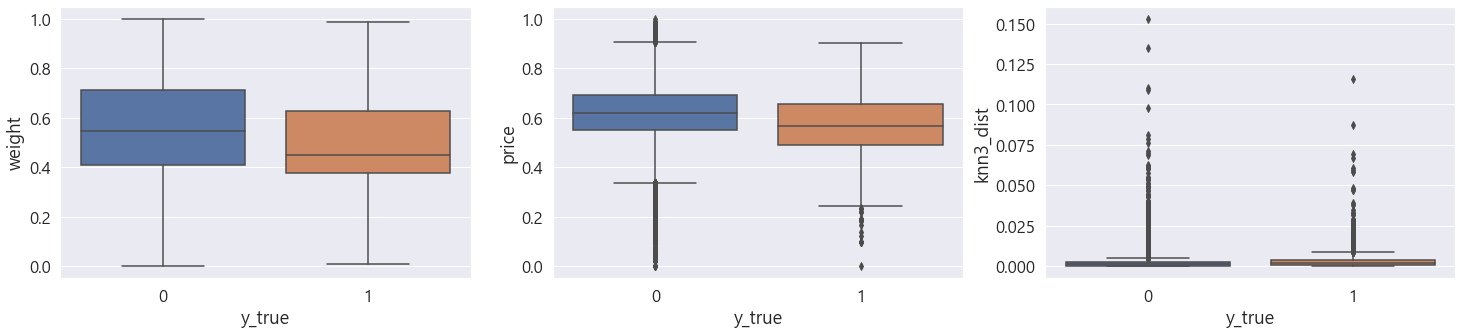

In [196]:
data['knn3_dist'] = distances.mean(axis =1)
cols= data.drop('y_true', axis=1).columns
fig, ax = plt.subplots(ncols=3, figsize=(25,5))
for i, col in enumerate(cols) :
    if i < 3:
        sns.boxplot(x= 'y_true', y= col, data=data, ax=ax[i])

In [197]:
nu_percentage= data['y_true'].value_counts(normalize=True).iloc[1]
print(f'부적합율(훈련데이터:X_train)은 {nu_percentage*100} %')

부적합율(훈련데이터:X_train)은 1.0824678957926772 %


## 3.2 NearestNeighbors(n_neighbors = 3, metric='mahalanobis')

## 3.3 Elliptic(Multivariate gaussian distribution) based on PCA

Text(0.5, 0, '주성분 개 수')

Text(0, 0.5, '총변동량 누적 설명 비율')

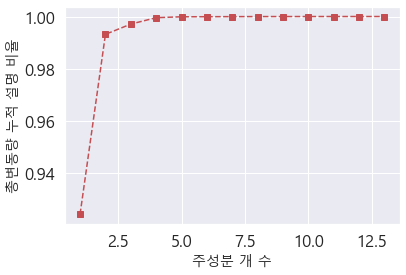

In [198]:
from sklearn.decomposition import PCA
pca = PCA().fit(X)
plt.plot(np.arange(1, X.shape[1]+1), np.cumsum(pca.explained_variance_ratio_), 'rs--')
plt.xlabel('주성분 개 수', fontsize='14'); plt.ylabel('총변동량 누적 설명 비율', fontsize='14')

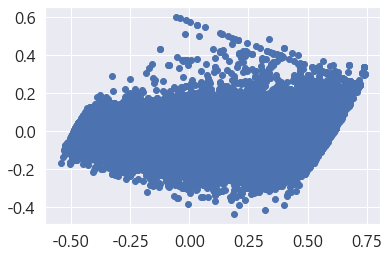

In [199]:
X_pca = PCA(n_components=2).fit(X).transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1])

In [200]:
from sklearn.covariance import EllipticEnvelope
X_pca = pd.DataFrame(X_pca, columns= ['pca_1', 'pca_2'])
el = EllipticEnvelope(contamination=y.mean())
el.fit(X_pca)
data['anomaly_score'] = el.decision_function(X_pca)
data['y_pred'] = el.predict(X_pca)

EllipticEnvelope(contamination=0.010824678957926772)

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'pca_1')

Text(0, 0.5, 'pca_2')

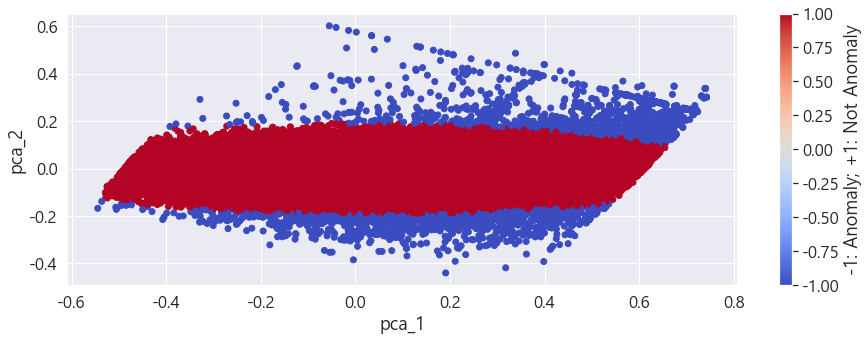

In [201]:
X_pca['Anomaly or Not'] = el.predict(X_pca)
# Create scatterplot and color the anomalies differently
plt.figure(figsize = (15, 5))
ax = plt.scatter(X_pca['pca_1'], X_pca['pca_2'], c = X_pca['Anomaly or Not'], cmap = 'coolwarm')
plt.xlabel('pca_1'); plt.ylabel('pca_2')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

## Anomaly score가 낮은 것이 이상치임

In [202]:
data['y_true'].value_counts()
data['y_pred'].value_counts()
data

0    362419
1      3966
Name: y_true, dtype: int64

 1    362416
-1      3969
Name: y_pred, dtype: int64

,weight,price,y_true,knn3_dist,anomaly_score,y_pred
1,0.855418,0.732446,0,0.000000e+00,12.100462,1
2,0.881669,0.818602,0,7.262344e-05,10.325505,1
3,0.622371,0.601616,0,1.739298e-03,13.660760,1
4,0.428168,0.533626,0,1.807004e-20,13.606329,1
5,0.654919,0.675759,0,1.235267e-03,14.098505,1
...,...,...,...,...,...,...
714384,0.668985,0.732757,0,7.821252e-04,12.604782,1
714387,0.341984,0.465367,0,1.232529e-03,11.786834,1
714390,0.381554,0.605846,0,2.599696e-05,12.287329,1
714395,0.437782,0.680680,0,3.159016e-03,9.807780,1


array([[358542,   3877],
       [  3874,     92]], dtype=int64)

<AxesSubplot:>

recall: 2.319717599596571,  precision: 2.3179642227261277


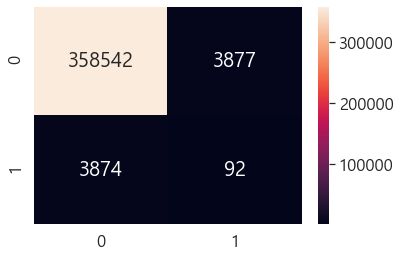

In [203]:
data['y_pred']= data['y_pred'].replace({1:0, -1:1})
from sklearn.metrics import confusion_matrix
cm= confusion_matrix(data['y_true'], data['y_pred'])
cm
sns.heatmap(cm, annot = True, fmt="d", annot_kws={"size": 20})
tn, fp, fn, tp = confusion_matrix(data['y_true'], data['y_pred']).ravel()
print(f'recall: {(tp/(tp+fn)*100)},  precision: {(tp/(tp+fp)*100)}')

<Figure size 576x360 with 0 Axes>

<AxesSubplot:xlabel='y_true', ylabel='anomaly_score'>

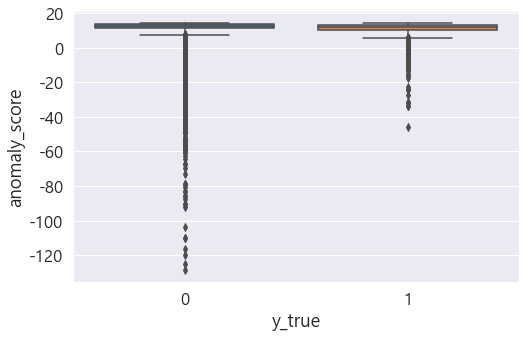

In [204]:
plt.figure(figsize = (8, 5))
sns.boxplot(x='y_true', y='anomaly_score', data=data)
#ax.boxplot([tips['total_bill'], tips['tip']], sym="b*")

## 3.4. Robust covariance estimation and Mahalanobis distances relevance¶
- https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.htmlm

In [206]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X_pca)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X_pca)
print('Estimated covariance matrix:\n'
      'MCD (Robust):\n{}\n'
      'MLE:\n{}'.format(robust_cov.covariance_, emp_cov.covariance_))

Estimated covariance matrix:
MCD (Robust):
[[ 0.04461999 -0.00057131]
 [-0.00057131  0.00253438]]
MLE:
[[4.70916430e-02 1.64217233e-16]
 [1.64217233e-16 3.51064218e-03]]


In [207]:
X = X_pca.copy()

In [208]:
n_outliers = data.y_true.value_counts()[1]
n_samples = len(data)

(-0.6088953955997959, 10.0)

Text(0.5, 1.0, 'Mahalanobis distances of a contaminated data set')

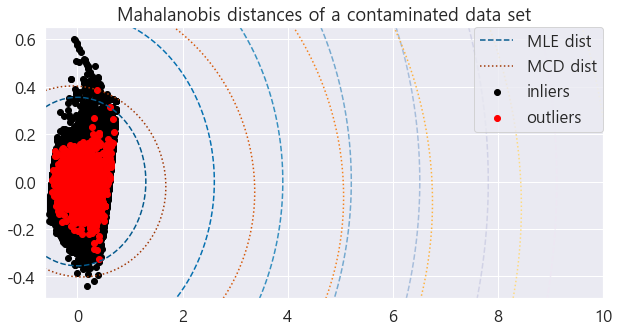

In [209]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color='black', label='inliers')
outlier_plot = ax.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color='red', label='outliers')
ax.set_xlim(ax.get_xlim()[0], 10.)
ax.set_title("Mahalanobis distances of a contaminated data set")

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(xx, yy, np.sqrt(mahal_emp_cov),
                              cmap=plt.cm.PuBu_r, linestyles='dashed')
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(xx, yy, np.sqrt(mahal_robust_cov),
                            cmap=plt.cm.YlOrBr_r, linestyles='dotted')

# Add legend
ax.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
          inlier_plot, outlier_plot],
          ['MLE dist', 'MCD dist', 'inliers', 'outliers'],
          loc="upper right", borderaxespad=0)

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x14d823ee250>,
 'caps': [<matplotlib.lines.Line2D at 0x14d823ee910>,
 'boxes': [<matplotlib.lines.Line2D at 0x14d823d7eb0>,
 'medians': [<matplotlib.lines.Line2D at 0x14d823eefd0>,
 'fliers': [<matplotlib.lines.Line2D at 0x14d823f9370>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using non-robust estimates\n(Maximum Likelihood)')

{'whiskers': [<matplotlib.lines.Line2D at 0x14d548d1760>,
 'caps': [<matplotlib.lines.Line2D at 0x14d548d1e20>,
 'boxes': [<matplotlib.lines.Line2D at 0x14d548d1400>,
 'medians': [<matplotlib.lines.Line2D at 0x14d548c8520>,
 'fliers': [<matplotlib.lines.Line2D at 0x14d548c8880>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using robust estimates\n(Minimum Covariance Determinant)')

{'whiskers': [<matplotlib.lines.Line2D at 0x14d548ebd30>,
 'caps': [<matplotlib.lines.Line2D at 0x14d548f4430>,
 'boxes': [<matplotlib.lines.Line2D at 0x14d548eb9d0>,
 'medians': [<matplotlib.lines.Line2D at 0x14d548f4af0>,
 'fliers': [<matplotlib.lines.Line2D at 0x14d548f4e50>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Eliiptic. dist.)}}$')

Text(0.5, 1.0, 'Using Multivariate Gaussian Estimates\n(EllipticEnvelope)')

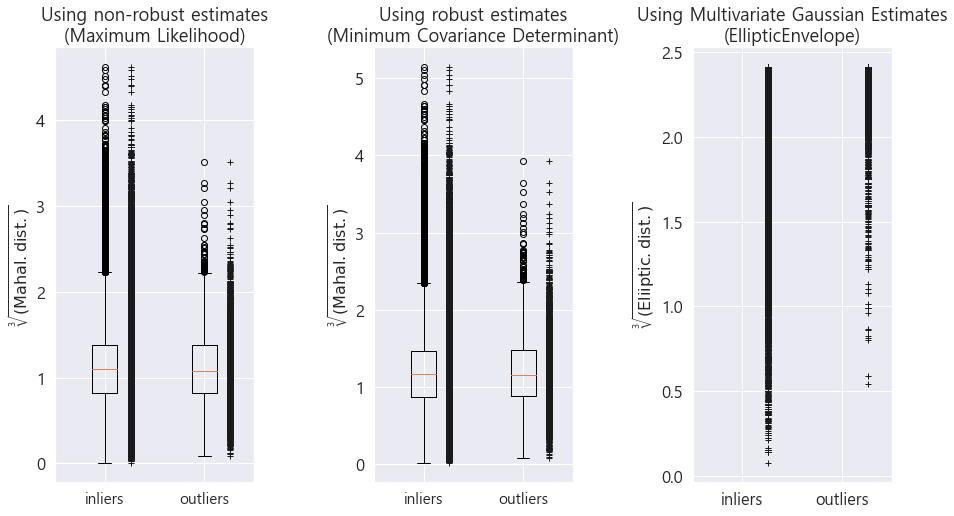

In [210]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,8))
plt.subplots_adjust(wspace=.6)
# Calculate cubic root of MLE Mahalanobis distances for samples
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
# Plot boxplots
ax1.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
# Plot individual samples
ax1.plot(np.full(n_samples - n_outliers, 1.26), emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
ax1.plot(np.full(n_outliers, 2.26), emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
ax1.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax1.set_title("Using non-robust estimates\n(Maximum Likelihood)")

# Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
# Plot boxplots
ax2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]], widths=.25)
# Plot individual samples
ax2.plot(np.full(n_samples - n_outliers, 1.26), robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
ax2.plot(np.full(n_outliers, 2.26), robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
ax2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax2.set_title("Using robust estimates\n(Minimum Covariance Determinant)")

# Calculate cubic root of Eclliptc distances for samples
eclliptic = el.decision_function(X_pca) ** (0.33)
# Plot boxplots
ax3.boxplot([eclliptic[:-n_outliers], eclliptic[-n_outliers:]], widths=0.25)
# Plot individual samples
ax3.plot(np.full(n_samples - n_outliers, 1.26), eclliptic[:-n_outliers], "+k", markeredgewidth=1,)
ax3.plot(np.full(n_outliers, 2.26), eclliptic[-n_outliers:], "+k", markeredgewidth=1)
ax3.axes.set_xticklabels(("inliers", "outliers"), size=16)
ax3.set_ylabel(r"$\sqrt[3]{\rm{(Eliiptic. dist.)}}$", size=16)
ax3.set_title("Using Multivariate Gaussian Estimates\n(EllipticEnvelope)")

plt.show()

plt.show()

<Figure size 576x360 with 0 Axes>

<AxesSubplot:xlabel='판정결과', ylabel='emp_mahal'>

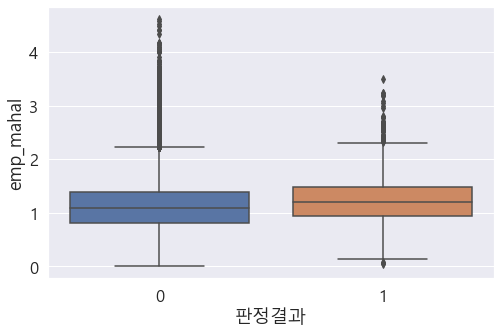

In [211]:
df['emp_mahal'] = emp_mahal
data= df[['판정결과', 'emp_mahal']]
plt.figure(figsize = (8, 5))
sns.boxplot(x='판정결과', y='emp_mahal', data=data)

In [212]:
df[df['판정결과'] == 1].sort_values('emp_mahal')

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log,emp_mahal
378382,빵류,판매용,태국,5.500,아니오,아니오,아니오,해당없음,N,N,N,1,6.579251,8.283999,0.054075
360396,소스,판매용,미국,5.317,아니오,아니오,아니오,해당없음,N,N,N,1,6.583409,8.254269,0.071434
407436,기타 식용유지가공품,판매용,독일,5.349,아니오,아니오,아니오,해당없음,N,N,N,1,6.559049,8.236034,0.083705
238741,빵류(그외 빵류),판매용,싱가포르,5.315,아니오,아니오,아니오,해당없음,N,N,N,1,6.527958,8.198458,0.142117
218288,빵류(그외 빵류),판매용,싱가포르,5.791,아니오,아니오,아니오,해당없음,N,N,N,1,6.527958,8.284237,0.142637
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97858,과자(스낵과자),판매용,일본,0.119,아니오,아니오,아니오,해당없음,N,N,N,1,2.128232,0.000000,3.179390
93983,과자(스낵과자),판매용,일본,0.109,아니오,아니오,아니오,해당없음,N,N,N,1,2.219203,0.000000,3.192462
75044,과자(스낵과자),판매용,일본,0.083,아니오,아니오,아니오,해당없음,N,N,N,1,2.484907,0.000000,3.231669
111099,과자(스낵과자),판매용,일본,0.083,아니오,아니오,아니오,해당없음,N,N,N,1,2.484907,0.000000,3.231669


In [213]:
data

,판정결과,emp_mahal
1,0,1.318068
2,0,1.530000
3,0,0.838525
4,0,0.860501
5,0,0.675899
...,...,...
714384,0,1.112008
714387,0,1.272953
714390,0,1.188701
714395,0,1.493682


In [214]:
oulier_max = data[data['판정결과'] == 1]['emp_mahal'].max()
data[data['emp_mahal'] <= oulier_max].shape
data.shape

(366304, 2)

(366385, 2)

In [246]:
oulier_min = data[data['판정결과'] == 1]['emp_mahal'].min()

data[data['emp_mahal'] > oulier_max].index
data[data['emp_mahal'] < oulier_min].index

Int64Index([  2710,   3904,  13177,  17721,  18344,  21249,  23021,  34593,
             45070,  77439,  88406,  89365,  91917, 105462, 107255, 112097,
            119190, 119612, 122487, 126120, 126882, 129724, 139420, 155459,
            173473, 186678, 187945, 215312, 216121, 223208, 235505, 237761,
            244095, 255661, 256614, 258200, 262978, 293082, 323398, 346038,
            373439, 380586, 381579, 382647, 382730, 393123, 411229, 422108,
            442839, 446031, 464103, 477321, 492148, 503084, 506986, 514594,
            515816, 518550, 520797, 539299, 560107, 567075, 574165, 593034,
            593891, 602277, 618190, 620925, 622789, 624500, 631072, 632666,
            633152, 635892, 641941, 644531, 645016, 683837, 690297, 691590,
            702551],
           dtype='int64')

Int64Index([  8719,  28860, 105048, 105853, 155055, 179027, 221281, 223560,
            231880, 258383, 330880, 352499, 364656, 388579, 452640, 492298,
            513459, 518732],
           dtype='int64')

In [215]:
oulier_min = df[df['판정결과'] == 1]['emp_mahal'].min()
df[df['emp_mahal'] <= oulier_min].shape
df.shape

(19, 15)

(366385, 15)

In [227]:
data['Predicted Probability'] = 'Predicted Probability'
data

,판정결과,emp_mahal,new_abnormal,Predicted Probability
1,0,1.318068,0,Predicted Probability
2,0,1.530000,0,Predicted Probability
3,0,0.838525,0,Predicted Probability
4,0,0.860501,0,Predicted Probability
5,0,0.675899,0,Predicted Probability
...,...,...,...,...
714384,0,1.112008,0,Predicted Probability
714387,0,1.272953,0,Predicted Probability
714390,0,1.188701,0,Predicted Probability
714395,0,1.493682,0,Predicted Probability


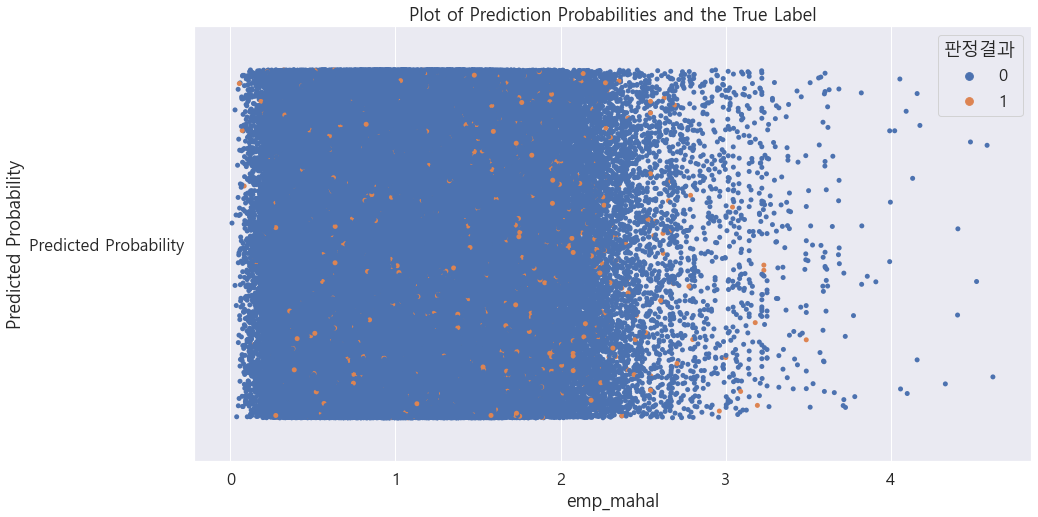

In [235]:
ax = sns.stripplot(x="emp_mahal", y="Predicted Probability",
                   hue='판정결과', jitter=0.4,
                   data=data).set_title('Plot of Prediction Probabilities and the True Label')

## Step 1. Low risk food clustering (신속통관)
### 이상치 점수가 어느 정도 이상 낮으면 정상이라고 판정

In [237]:
min_abonormal = data[data['판정결과'] == 1]['emp_mahal'].min()
min_abonormal
data.loc[data['emp_mahal'] < min_abonormal, '판정결과'].sum()
data['emp_mahal'].max()

0.05407528731043696

0

4.619206287269896

In [241]:
recalls =[]
precisions =[]
f1scores=[]
ratios=[]
thresholds=data['emp_mahal'].quantile(np.arange(0, 1, 0.05))
for threshold in thresholds:
    data['new_abnormal'] = 0
    data.loc[data['emp_mahal'] > threshold, 'new_abnormal'] = 1
    #confusion_matrix(data['y_true'], data['new_abnormal'])
    tn, fp, fn, tp = confusion_matrix(data['판정결과'], data['new_abnormal']).ravel()
    recall = tp/(tp+fn)
    precision = tp/(tp+fp)
    f1score = 2*recall*precision/(recall+precision)
    ratio = (tp+fp)/(tn + fp + fn + tp)
    recalls.append(recall)
    precisions.append(precision)
    f1scores.append(f1score)
    ratios.append(ratio)
    print(f'임계값(Anomaly score): {threshold:.2f}, recall: {(tp/(tp+fn)*100):.3f}%,  precision: {(tp/(tp+fp)*100):.3f}%')

임계값(Anomaly score): 0.01, recall: 100.000%,  precision: 1.082%
임계값(Anomaly score): 0.46, recall: 96.470%,  precision: 1.099%
임계값(Anomaly score): 0.59, recall: 93.343%,  precision: 1.123%
임계값(Anomaly score): 0.68, recall: 89.813%,  precision: 1.144%
임계값(Anomaly score): 0.75, recall: 86.283%,  precision: 1.167%
임계값(Anomaly score): 0.82, recall: 82.905%,  precision: 1.197%
임계값(Anomaly score): 0.88, recall: 79.274%,  precision: 1.226%
임계값(Anomaly score): 0.94, recall: 74.836%,  precision: 1.246%
임계값(Anomaly score): 0.99, recall: 68.709%,  precision: 1.240%
임계값(Anomaly score): 1.04, recall: 63.666%,  precision: 1.253%
임계값(Anomaly score): 1.10, recall: 59.481%,  precision: 1.288%
임계값(Anomaly score): 1.15, recall: 54.614%,  precision: 1.314%
임계값(Anomaly score): 1.21, recall: 49.420%,  precision: 1.337%
임계값(Anomaly score): 1.27, recall: 44.831%,  precision: 1.387%
임계값(Anomaly score): 1.33, recall: 39.410%,  precision: 1.422%
임계값(Anomaly score): 1.38, recall: 33.459%,  precision: 1.449%
임계값(Ano

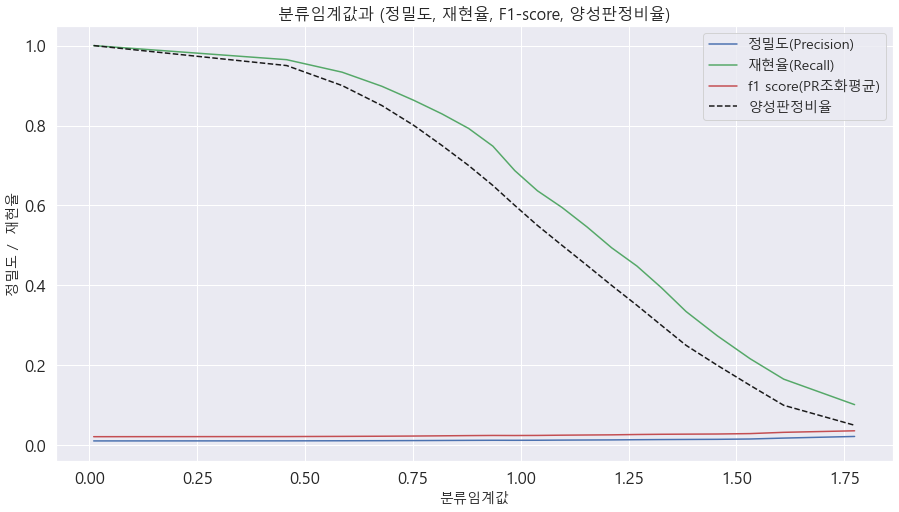

In [224]:
def plot_precision_recall_vs_threshold(precisions, recalls, f1scores, ratios, thresholds): 
    plt.rcParams["figure.figsize"] = (15,8)
    plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
    plt.title('분류임계값과 (정밀도, 재현율, F1-score, 양성판정비율)', fontsize='16') 
    plt.plot(thresholds, precisions, 'b-', label='정밀도(Precision)') # 판사
    plt.plot(thresholds, recalls, 'g-', label='재현율(Recall)') # 검사
    plt.plot(thresholds, f1scores, 'r-', label='f1 score(PR조화평균)') # 변호사
    plt.plot(thresholds, ratios, 'k--', label='양성판정비율') # q-ratio
    plt.ylabel('정밀도 /  재현율', fontsize='14') 
    plt.xlabel('분류임계값', fontsize='14') 
    plt.legend(loc='best', fontsize='14') 
    
plot_precision_recall_vs_threshold(precisions, recalls, f1scores, ratios, thresholds)

<img src = 'https://wikimedia.org/api/rest_v1/media/math/render/svg/d37e557b5bfc8de22afa8aad1c187a357ac81bdb'>

# End

In [225]:
error

NameError: name 'erroe' is not defined

### 2.1 이상치 탐색 with DTW
- 모든 특성변수는 자료표준화가 되어 0~1 사이의 값으로 존재하게 되어 dtw(dynamic time warping)거리fmf 기준으로 Anomaly detection
- https://en.wikipedia.org/wiki/Dynamic_time_warping
- https://dinhanhthi.com/dynamic-time-warping-dtw/

In [51]:
from tslearn.clustering import TimeSeriesKMeans
km = TimeSeriesKMeans(n_clusters=2, metric="dtw")
km.fit(X)
y_pred = km.fit_predict(X)
y_score = km.fit_transform(X)

KeyboardInterrupt: 

In [46]:
y_pred
y_pred.shape
y_score
y_score.shape

array([0, 1, 1, ..., 1, 0, 0], dtype=int64)

(13755,)

array([[0.20347875, 0.2162506 ],
       [0.33215734, 0.21686103],
       [0.58201344, 0.18610298],
       ...,
       [0.42150116, 0.0318137 ],
       [0.05571701, 0.37682684],
       [0.13046282, 0.26624076]])

(13755, 2)

In [48]:
del data['new_abnormal']

In [49]:
data['y_pred_dtw'] = y_pred
data['y_normal_score_dtw'] = y_score[:, 0]
data['y_abnormal_score_dtw'] = y_score[:, 1]
data.head()

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.203479,0.216251
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.332157,0.216861
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.582013,0.186103
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.512226,0.184541
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.160252,0.239185


In [50]:
data['y_normal_score_dtw'] = data['y_normal_score_dtw']/(data['y_normal_score_dtw'] + data['y_abnormal_score_dtw'])
data['y_abnormal_score_dtw']= data['y_abnormal_score_dtw']/(data['y_normal_score_dtw'] + data['y_abnormal_score_dtw'])
data.head()

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.484786,0.308473
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.605002,0.263865
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.757715,0.197181
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.735147,0.200656
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.401195,0.373505


array([[7384, 6208],
       [ 105,   58]], dtype=int64)

<AxesSubplot:>

(7384, 6208, 105, 58)

recall: 0.3558282208588957,  precision: 0.00925630386211299


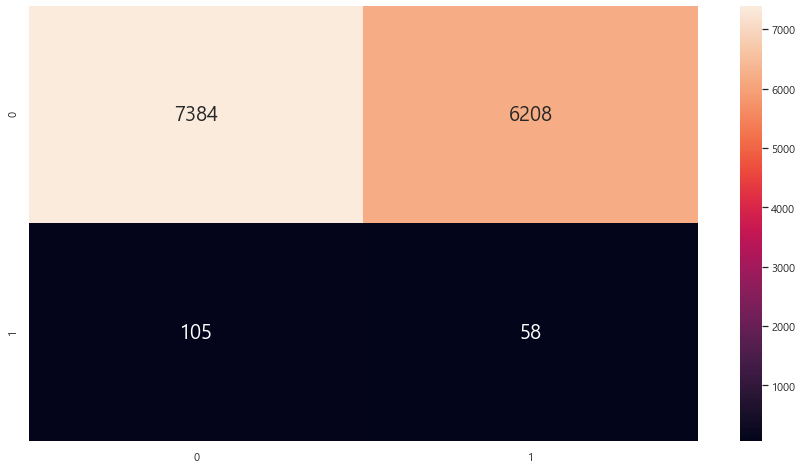

In [51]:
cm = confusion_matrix(data['y_true'], data['y_pred_dtw'])
cm
sns.heatmap(cm, annot = True, fmt="d", annot_kws={"size": 20})
tn, fp, fn, tp = confusion_matrix(data['y_true'], data['y_pred_dtw']).ravel()
tn, fp, fn, tp 
print(f'recall: {tp/(tp+fn)},  precision: {tp/(tp+fp)}')

In [52]:
from sklearn.metrics import classification_report
target_names = ['적합(0)', '부적합(1)']
print(classification_report(data['y_true'], data['y_pred_dtw'], target_names=target_names))

              precision    recall  f1-score   support

       적합(0)       0.99      0.54      0.70     13592
      부적합(1)       0.01      0.36      0.02       163

    accuracy                           0.54     13755
   macro avg       0.50      0.45      0.36     13755
weighted avg       0.97      0.54      0.69     13755



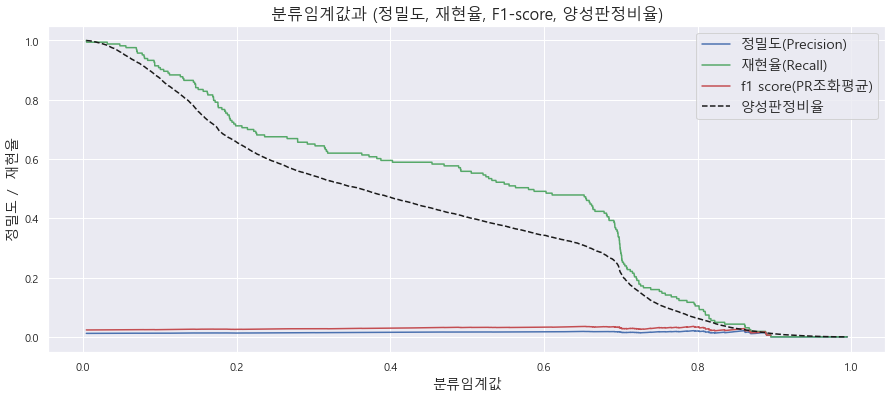

In [53]:
from sklearn.metrics import precision_recall_curve

def to_labels(pos_probs, threshold):
    return (pos_probs >= threshold).astype('int')
p, r, thresholds = precision_recall_curve(data['y_true'], data['y_abnormal_score_dtw'])

scores = [np.sum(to_labels(data['y_abnormal_score_dtw'], t))/len(data) for t in thresholds]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds): 
    plt.rcParams["figure.figsize"] = (15,6)
    plt.rcParams['font.family']='Malgun Gothic' # 한글폰트
    plt.title('분류임계값과 (정밀도, 재현율, F1-score, 양성판정비율)', fontsize='16') 
    plt.plot(thresholds, precisions[:-1], 'b-', label='정밀도(Precision)') # 판사
    plt.plot(thresholds, recalls[:-1], 'g-', label='재현율(Recall)') # 검사
    plt.plot(thresholds, (2*precisions[:-1]*recalls[:-1])/(precisions[:-1] +recalls[:-1]), 
             'r-', label='f1 score(PR조화평균)') # 변호사
    plt.plot(thresholds, scores, 'k--', label='양성판정비율') # q-ratio
    plt.ylabel('정밀도 /  재현율', fontsize='14') 
    plt.xlabel('분류임계값', fontsize='14') 
    plt.legend(loc='best', fontsize='14') 
    
plot_precision_recall_vs_threshold(p, r, thresholds)

In [56]:
data

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.484786,0.308473
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.605002,0.263865
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.757715,0.197181
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.735147,0.200656
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.401195,0.373505
...,...,...,...,...,...,...,...,...,...
1749366,0.708465,0.707741,0,0.002485,14.135439,0,1,0.817237,0.081982
680175,0.544920,0.613473,0,0.002243,14.460331,0,0,0.347306,0.427472
1132812,0.767909,0.792084,0,0.015411,13.443363,0,1,0.929820,0.033083
2079622,0.413452,0.608788,0,0.006656,13.402480,0,0,0.128812,0.745248


<AxesSubplot:xlabel='y_normal_score_dtw', ylabel='y_abnormal_score_dtw'>

<AxesSubplot:xlabel='y_normal_score_dtw', ylabel='y_abnormal_score_dtw'>

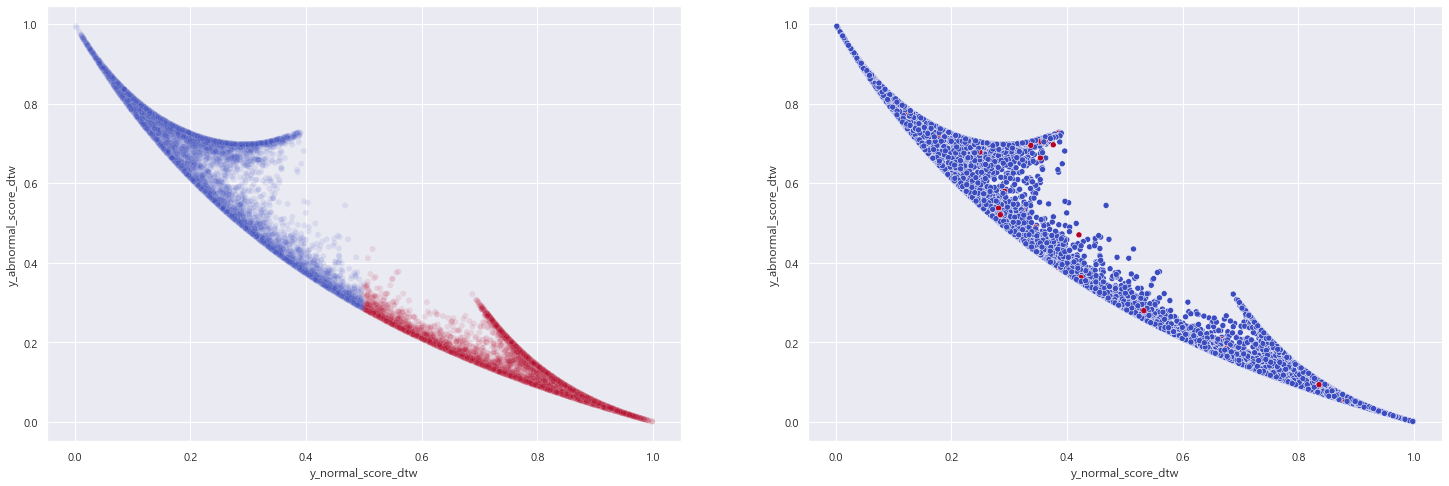

In [80]:
fig, ax = plt.subplots(ncols=2, figsize=(25,8))
sns.scatterplot(data['y_normal_score_dtw'], data['y_abnormal_score_dtw'], c = data['y_pred_dtw'],
                cmap = 'coolwarm', alpha=0.1, ax=ax[0])
sns.scatterplot(data['y_normal_score_dtw'], data['y_abnormal_score_dtw'], c = data['y_true'],
                cmap = 'coolwarm', ax=ax[1])

<Figure size 1080x360 with 0 Axes>

Text(0.5, 0, 'normal_score')

Text(0, 0.5, 'anomaly_score')

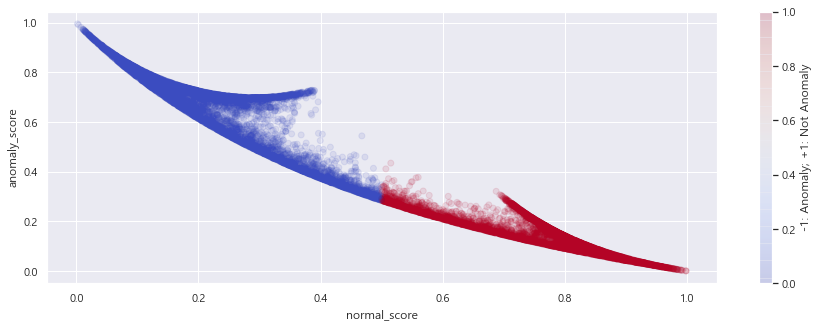

In [81]:
plt.figure(figsize = (15, 5))
ax = plt.scatter(data['y_normal_score_dtw'], data['y_abnormal_score_dtw'], c = data['y_pred_dtw'], 
                 cmap = 'coolwarm', alpha=0.1)
plt.xlabel('normal_score'); plt.ylabel('anomaly_score')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

Text(0.5, 0, 'normal_score')

Text(0, 0.5, 'anomaly_score')

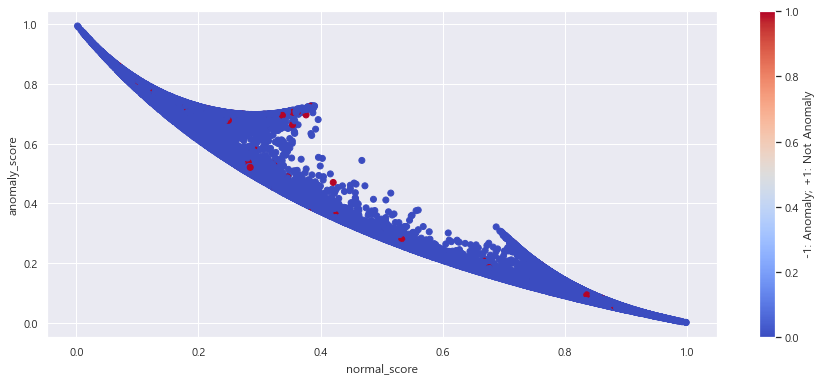

In [82]:
ax = plt.scatter(data['y_normal_score_dtw'], data['y_abnormal_score_dtw'], c = data['y_true'], 
                 cmap = 'coolwarm')
plt.xlabel('normal_score'); plt.ylabel('anomaly_score')
plt.colorbar(label = '-1: Anomaly; +1: Not Anomaly')

In [83]:
data.head()

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.484786,0.308473
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.605002,0.263865
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.757715,0.197181
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.735147,0.200656
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.401195,0.373505


Text(0.5, 1.0, '이상치 점수와 적합부적합')

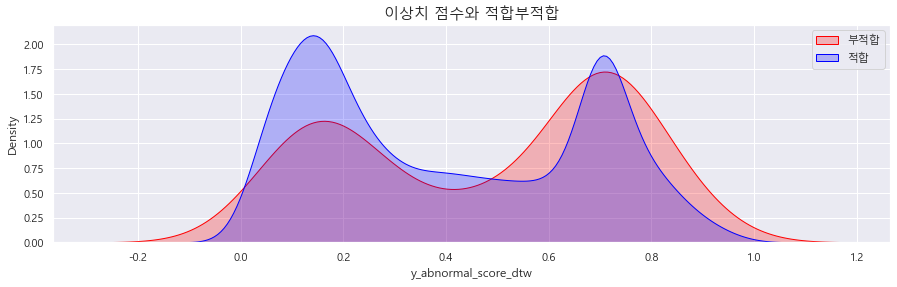

In [84]:
fig = plt.figure(figsize=(15,4))
ax=sns.kdeplot(data.loc[data['y_true'] == 1, 'y_abnormal_score_dtw'], color='red', shade=True, label='부적합')
ax=sns.kdeplot(data.loc[data['y_true'] == 0, 'y_abnormal_score_dtw'], color='blue', shade=True, label='적합')
plt.legend()
plt.title('이상치 점수와 적합부적합', fontsize =15)

### 부적합 판정결과의 이상치수치가 upper/lower limit 이상이하인 데이터는 제외

<AxesSubplot:xlabel='y_true', ylabel='y_abnormal_score_dtw'>

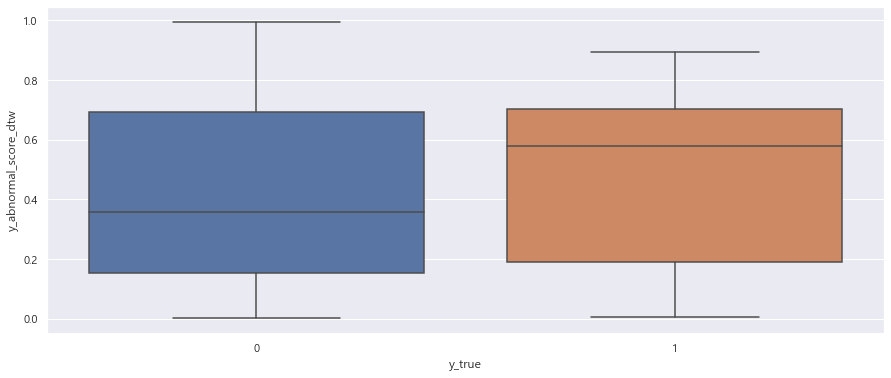

In [85]:
sns.boxplot(x = "y_true", y = "y_abnormal_score_dtw", data = data)

In [86]:
data.head()

,weight,price,y_true,knn3_dist,anomaly_score,y_pred,y_pred_dtw,y_normal_score_dtw,y_abnormal_score_dtw
1058119,0.546655,0.713491,0,0.005318,13.338904,0,0,0.484786,0.308473
2906068,0.562211,0.854097,0,0.023341,5.958149,0,1,0.605002,0.263865
1096033,0.921934,0.849240,0,0.006244,11.651032,0,1,0.757715,0.197181
873289,0.919262,0.671140,0,0.012177,6.502125,0,1,0.735147,0.200656
389632,0.568699,0.614988,0,0.004093,14.388150,0,0,0.401195,0.373505


In [87]:
data['y_abnormal_score_dtw'].max()

0.9946735431278282

In [88]:
data[data['y_abnormal_score_dtw'] > max_abonormal]['y_true'].sum()
data[data['y_normal_score_dtw'] > max_abonormal]['y_true'].sum()

0

3

In [89]:
max_abonormal = data[data['y_true'] == 1]['y_abnormal_score_dtw'].max()
max_abonormal
data.loc[data['y_normal_score_dtw'] > max_abonormal, 'y_true']
data.loc[data['y_normal_score_dtw'] > max_abonormal, 'y_true'].sum()

0.8951169432586579

2042872    0
2225070    0
2920555    0
821603     0
1658680    0
          ..
67363      0
350463     0
310402     0
246097     0
1132812    0
Name: y_true, Length: 561, dtype: int64

3

In [16]:
index = data[~((data['y_score_0'] < l_fence) | (data['y_score_0'] > u_fence))].index

In [17]:
index

Int64Index([2225054,  255568,  130945, 2089969,  193189,  705775, 1841778,
            1555938,  134428,  506178,
            ...
            1629433, 1173186,  966207, 2994311, 2117330, 1878562, 1761179,
             194046, 2441814,  923283],
           dtype='int64', length=68551)

### Algorithm selection for Anomaly Detection
- https://medium.com/analytics-vidhya/algorithm-selection-for-anomaly-detection-ef193fd0d6d1
<img src= 'https://miro.medium.com/max/1072/1*OIXCo35Vvzr9qoUbV2fHMA.png'>

### <font color='brown'> Unsupervised learning anomaly detection methods
<img src='https://miro.medium.com/max/1540/1*7yJ2KiW3RFHP2nJppTP4mw.png'>

# 3. 지도학습 예측
- 이상치 score로 downsizing된 데이터를 만든다

In [42]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import plot_confusion_matrix, classification_report

In [24]:
data = df[df.index.isin(index)]
data.shape
data.head()

(68551, 14)

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
2225054,즉석조리식품,판매용,인도네시아,3.647,아니오,아니오,아니오,표시함,N,N,N,0,6.546785,7.839526
255568,배추김치,판매용,중국,0.460,아니오,아니오,아니오,해당없음,N,N,N,0,8.987322,8.210940
130945,과실주,판매용,호주,11.692,아니오,아니오,아니오,해당없음,N,N,N,0,6.916715,9.374673
2089969,기타 수산물가공품,판매용,베트남,5.400,아니오,아니오,아니오,표시함,N,N,N,0,9.287394,10.973718
193189,과실주,판매용,프랑스,2.333,아니오,아니오,아니오,해당없음,N,N,N,0,8.412055,9.259226


- 훈련/검증 데이터 분리

In [25]:
X = data.drop('판정결과', axis=1)
y = data['판정결과']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2)

In [28]:
from sklearn.model_selection import StratifiedKFold
skf = StratifiedKFold(n_splits=5)

In [38]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=3)
    
    numeric_transformer = Pipeline(steps=[('scaler', MinMaxScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier())])
        
    grid_search = RandomizedSearchCV(pipe, {}, 
                                     scoring='recall', 
                                     refit = refit_score,
                                     cv = skf, 
                                     return_train_score=True, n_jobs=-1)
    
    grid_search.fit(X_train, y_train)

    # make the predictions
    y_pred = grid_search.predict(X_test)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    print(classification_report(y_test, y_pred))
    
    return grid_search

In [43]:
grid_search_clf = grid_search_wrapper(refit_score='precision_score')

Best params for precision_score
{}

Confusion matrix of Random Forest optimized for precision_score on the test data:
     pred_neg  pred_pos
neg     13539        13
pos       157         2
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     13552
           1       0.13      0.01      0.02       159

    accuracy                           0.99     13711
   macro avg       0.56      0.51      0.51     13711
weighted avg       0.98      0.99      0.98     13711



# 3. Oversampling 예측
- recall 이 높은 알고리즘 선택

In [44]:
from imblearn.under_sampling import *
from imblearn.pipeline import Pipeline, make_pipeline  # scikit-learn의 pipeline을 사용하지 마라!

In [45]:
randomseed = 1024

def classification_result_imbalance(imbalance_method=RandomUnderSampler(random_state=randomseed), refit_score='recall_score'):
    skf = StratifiedKFold(n_splits=3)
    numeric_transformer = Pipeline(steps=[('scaler', StandardScaler())])
    categorical_transformer = Pipeline(steps=[('catencoder', ce.woe.WOEEncoder())])
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])
    pipe = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('imbalance sampler', imbalance_method),
        ('classifier', RandomForestClassifier())])
    
    smote_pipeline = make_pipeline(preprocessor,
                                   imbalance_method,
                                   RandomForestClassifier())
    
    grid_search = RandomizedSearchCV(smote_pipeline, {},
                                     scoring= 'recall', 
                                     refit = refit_score,
                                     cv = skf)
    
    grid_search.fit(X_train, y_train)
    y_pred = grid_search.predict(X_test)
    print(classification_report(y_test, y_pred))  
    return grid_search

In [47]:
under_sampling_methods = [RandomUnderSampler(random_state=randomseed)]

for mine in under_sampling_methods:
    mine
    grid_search_clf = classification_result_imbalance(imbalance_method=mine, refit_score='recall_score')

RandomUnderSampler(random_state=1024)

              precision    recall  f1-score   support

           0       1.00      0.74      0.85     13552
           1       0.03      0.74      0.06       159

    accuracy                           0.74     13711
   macro avg       0.51      0.74      0.46     13711
weighted avg       0.98      0.74      0.84     13711



# End

# Robust covariance estimation and Mahalanobis distances relevance
- https://scikit-learn.org/stable/auto_examples/covariance/plot_mahalanobis_distances.htmlm

In [85]:
# for consistent results
np.random.seed(7)

n_samples = 125
n_outliers = 25
n_features = 2

# generate Gaussian data of shape (125, 2)
gen_cov = np.eye(n_features)
gen_cov[0, 0] = 2.
X = np.dot(np.random.randn(n_samples, n_features), gen_cov)
# add some outliers
outliers_cov = np.eye(n_features)
outliers_cov[np.arange(1, n_features), np.arange(1, n_features)] = 7.
X[-n_outliers:] = np.dot(np.random.randn(n_outliers, n_features), outliers_cov)

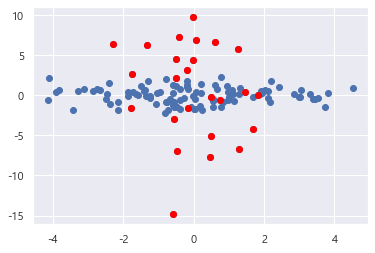

In [86]:
plt.scatter(X[:, 0], X[:, 1])
plt.scatter(X[-n_outliers:][:, 0], X[-n_outliers:][:, 1], color = 'red')

In [87]:
from sklearn.covariance import EmpiricalCovariance, MinCovDet
# fit a MCD robust estimator to data
robust_cov = MinCovDet().fit(X)
# fit a MLE estimator to data
emp_cov = EmpiricalCovariance().fit(X)
print('Estimated covariance matrix:\n'
      'MCD (Robust):\n{}\n'
      'MLE:\n{}'.format(robust_cov.covariance_, emp_cov.covariance_))

Estimated covariance matrix:
MCD (Robust):
[[ 3.26253567e+00 -3.06695631e-03]
 [-3.06695631e-03  1.22747343e+00]]
MLE:
[[ 3.23773583 -0.24640578]
 [-0.24640578  7.51963999]]


(-4.561265785217095, 10.0)

Text(0.5, 1.0, 'Mahalanobis distances of a contaminated data set')

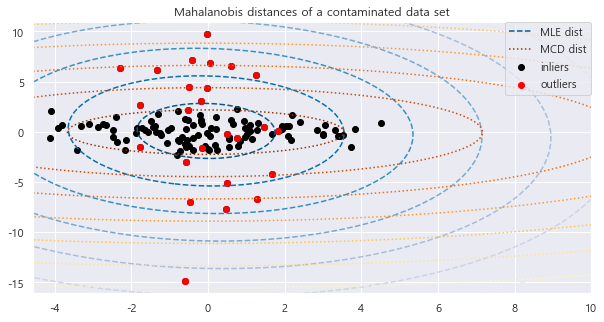

In [88]:
fig, ax = plt.subplots(figsize=(10, 5))
# Plot data set
inlier_plot = ax.scatter(X[:, 0], X[:, 1], color='black', label='inliers')
outlier_plot = ax.scatter(X[:, 0][-n_outliers:], X[:, 1][-n_outliers:], color='red', label='outliers')
ax.set_xlim(ax.get_xlim()[0], 10.)
ax.set_title("Mahalanobis distances of a contaminated data set")

# Create meshgrid of feature 1 and feature 2 values
xx, yy = np.meshgrid(np.linspace(plt.xlim()[0], plt.xlim()[1], 100),
                     np.linspace(plt.ylim()[0], plt.ylim()[1], 100))
zz = np.c_[xx.ravel(), yy.ravel()]
# Calculate the MLE based Mahalanobis distances of the meshgrid
mahal_emp_cov = emp_cov.mahalanobis(zz)
mahal_emp_cov = mahal_emp_cov.reshape(xx.shape)
emp_cov_contour = plt.contour(xx, yy, np.sqrt(mahal_emp_cov),
                              cmap=plt.cm.PuBu_r, linestyles='dashed')
# Calculate the MCD based Mahalanobis distances
mahal_robust_cov = robust_cov.mahalanobis(zz)
mahal_robust_cov = mahal_robust_cov.reshape(xx.shape)
robust_contour = ax.contour(xx, yy, np.sqrt(mahal_robust_cov),
                            cmap=plt.cm.YlOrBr_r, linestyles='dotted')

# Add legend
ax.legend([emp_cov_contour.collections[1], robust_contour.collections[1],
          inlier_plot, outlier_plot],
          ['MLE dist', 'MCD dist', 'inliers', 'outliers'],
          loc="upper right", borderaxespad=0)

plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x1d8409b6910>,
 'caps': [<matplotlib.lines.Line2D at 0x1d8409b6fd0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d8409b65b0>,
 'medians': [<matplotlib.lines.Line2D at 0x1d8409c46d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d8409c4a60>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using non-robust estimates\n(Maximum Likelihood)')

{'whiskers': [<matplotlib.lines.Line2D at 0x1d8409ed190>,
 'caps': [<matplotlib.lines.Line2D at 0x1d8409ed850>,
 'boxes': [<matplotlib.lines.Line2D at 0x1d8409d8d30>,
 'medians': [<matplotlib.lines.Line2D at 0x1d8409edf10>,
 'fliers': [<matplotlib.lines.Line2D at 0x1d8409f82b0>,
 'means': []}

[Text(1, 0, 'inliers'), Text(2, 0, 'outliers')]

Text(0, 0.5, '$\\sqrt[3]{\\rm{(Mahal. dist.)}}$')

Text(0.5, 1.0, 'Using robust estimates\n(Minimum Covariance Determinant)')

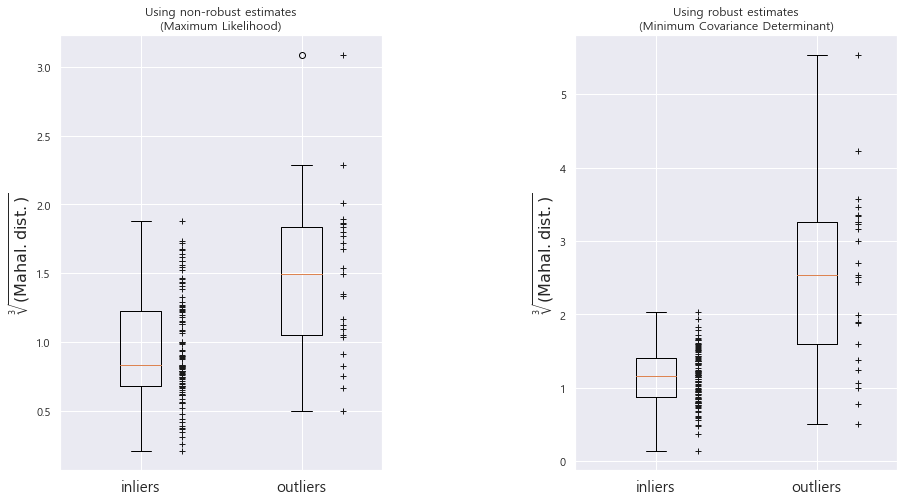

In [89]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,8))
plt.subplots_adjust(wspace=.6)
# Calculate cubic root of MLE Mahalanobis distances for samples
emp_mahal = emp_cov.mahalanobis(X - np.mean(X, 0)) ** (0.33)
# Plot boxplots
ax1.boxplot([emp_mahal[:-n_outliers], emp_mahal[-n_outliers:]], widths=.25)
# Plot individual samples
ax1.plot(np.full(n_samples - n_outliers, 1.26), emp_mahal[:-n_outliers], '+k', markeredgewidth=1)
ax1.plot(np.full(n_outliers, 2.26), emp_mahal[-n_outliers:], '+k', markeredgewidth=1)
ax1.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax1.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax1.set_title("Using non-robust estimates\n(Maximum Likelihood)")

# Calculate cubic root of MCD Mahalanobis distances for samples
robust_mahal = robust_cov.mahalanobis(X - robust_cov.location_) ** (0.33)
# Plot boxplots
ax2.boxplot([robust_mahal[:-n_outliers], robust_mahal[-n_outliers:]], widths=.25)
# Plot individual samples
ax2.plot(np.full(n_samples - n_outliers, 1.26), robust_mahal[:-n_outliers], '+k', markeredgewidth=1)
ax2.plot(np.full(n_outliers, 2.26), robust_mahal[-n_outliers:], '+k', markeredgewidth=1)
ax2.axes.set_xticklabels(('inliers', 'outliers'), size=15)
ax2.set_ylabel(r"$\sqrt[3]{\rm{(Mahal. dist.)}}$", size=16)
ax2.set_title("Using robust estimates\n(Minimum Covariance Determinant)")

plt.show()

#  2. Semi-Supervised learning (Novelty detection)
## One-class SVM with non-linear kernel (RBF)
- OCSVM assumes that anomalies can form dense clusters as long as they form a low-density region in the training dataset.
- OCSVM mode is trained in only one class, referred to as the normal class. The model learns all the features and patterns of the normal class 
- https://scikit-learn.org/stable/modules/generated/sklearn.svm.OneClassSVM.html#sklearn.svm.OneClassSVM

#### <p> <font color= 'blue'> Intuition : One-class SVM is based on SVM, which uses a hyperplane to seperate two classes while a  <b>One-class SVM uses a hypersphere to emcompass all of the observations<b> <p>

In [105]:
df= tf.copy()
train_rec_count=int(len(df)*.8)
df_train= df.iloc[:train_rec_count,:]
df_train.shape
df_train.head()
df_train['판정결과'].value_counts(normalize=True)

(11004, 14)

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1663960,0.000000,0.011355,0.001769,0.000500,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.568702,0.664566
2312845,0.008032,0.011355,0.001769,0.000375,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.472120,0.553561
2205920,0.017202,0.018927,0.001769,0.000421,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.828743,0.881663
1644698,0.011173,0.011355,0.009709,0.000278,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.335609,0.405416
2063361,0.010169,0.011355,0.001769,0.000494,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.396945,0.510000


0    0.987732
1    0.012268
Name: 판정결과, dtype: float64

In [107]:
df_test=df.iloc[train_rec_count:,:]
df_test.shape
df_test.head()
df_test['판정결과'].value_counts(normalize=True)

(2751, 14)

,유형,용도명,제조국(원산지),과세가격($/Kg),유기식품 여부,영유아섭취대상,주문자상표부착,유전자변형식품,가온보존대상,진균수시험대상,방사선조사식품,판정결과,순중량(Kg)_log,과세가격_log
1787451,0.000000,0.011355,0.006404,0.003122,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.379082,0.652285
2322748,0.000000,0.011355,0.006404,0.000424,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.512088,0.599961
383035,0.000000,0.011355,0.000000,0.000246,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.734091,0.751004
1851180,0.008032,0.011355,0.001769,0.001867,0.011347,0.011487,0.011562,0.012078,0.011502,0.011092,0.011459,0,0.556829,0.767218
350816,0.000000,0.011355,0.001769,0.001948,0.011347,0.011487,0.011562,0.012078,0.011502,0.027950,0.011459,0,0.391934,0.623295


0    0.991639
1    0.008361
Name: 판정결과, dtype: float64

### 정상과 비정상이 있는 훈련데이터(X_train, y_train)

In [108]:
X_train= df_train.drop('판정결과', axis=1)
y_train= df_train['판정결과']
y_train.value_counts(normalize=True)
X_train.shape, y_train.shape

0    0.987732
1    0.012268
Name: 판정결과, dtype: float64

((11004, 13), (11004,))

### 검증데이터(X_test)

In [109]:
X_test= df_test.drop('판정결과', axis=1)
y_test= df_test['판정결과']
y_test.value_counts(normalize=True)
X_test.shape, y_test.shape

0    0.991639
1    0.008361
Name: 판정결과, dtype: float64

((2751, 13), (2751,))

### Creating the One-Class Support Vector Macine

In [110]:
nu_percentage= df_train['판정결과'].value_counts(normalize=True).iloc[1]
print(f'부적합율(훈련데이터:X_train)은 {nu_percentage*100} %')

부적합율(훈련데이터:X_train)은 1.2268266085059978 %


In [111]:
from sklearn.svm import OneClassSVM
ocsvm = OneClassSVM(nu=nu_percentage) # OneClassSVM(kernel='rbf', nu=0.0005, gamma=0.007)

In [127]:
ocsvm.get_params()

{'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'nu': 0.012268266085059978,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

## 2.1. 지도학습 : 지도학습후 예측결과(yhat)와 실제자료(df_test)와 비교 

In [119]:
df_test.판정결과.value_counts()
df_test.onesvm_anomaly.value_counts()

0    2728
1      23
Name: 판정결과, dtype: int64

 1    2721
-1      30
Name: onesvm_anomaly, dtype: int64

OneClassSVM(nu=0.012268266085059978)

<AxesSubplot:>

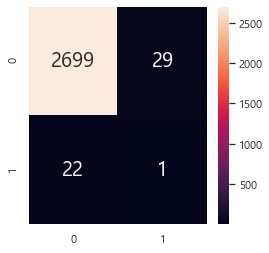

In [125]:
ocsvm.fit(X_train, y_train)
from sklearn.metrics import confusion_matrix

yhat=ocsvm.predict(X_test)

df_test['onesvm_anomaly']= yhat
df_test['onesvm_anomaly'] = df_test['onesvm_anomaly'].replace({1:0,-1:1})

cm=confusion_matrix(df_test['판정결과'], df_test['onesvm_anomaly'])
plt.rcParams["figure.figsize"] = (4,4)
sns.heatmap(cm, annot = True, fmt="d", annot_kws={"size": 20})

In [126]:
from sklearn.metrics import classification_report
target_names = ['Normal(1)', 'Abnormal(-1)']
print(classification_report(df_test['판정결과'], df_test['onesvm_anomaly'], target_names=target_names))

              precision    recall  f1-score   support

   Normal(1)       0.99      0.99      0.99      2728
Abnormal(-1)       0.03      0.04      0.04        23

    accuracy                           0.98      2751
   macro avg       0.51      0.52      0.51      2751
weighted avg       0.98      0.98      0.98      2751



In [129]:
from sklearn.metrics import accuracy_score, precision_score, recall_score
print(" Accuracy Score for One-Class SVM :", accuracy_score(df_test['판정결과'], df_test['onesvm_anomaly']))
print(" Precision for One-Class SVM :", precision_score(df_test['판정결과'], df_test['onesvm_anomaly']))
print(" Recall for One-Class SVM :", recall_score(df_test['판정결과'], df_test['onesvm_anomaly']))
print(" Confusion Matrix: \n", cm)

 Accuracy Score for One-Class SVM : 0.9814612868047983
 Precision for One-Class SVM : 0.03333333333333333
 Recall for One-Class SVM : 0.043478260869565216
 Confusion Matrix: 
 [[2699   29]
 [  22    1]]


## 2.2. 비지도학습 훈련

In [ ]:
ocsvm = OneClassSVM(nu=nu_percentage)
ocsvm.fit(X_train)

<AxesSubplot:>

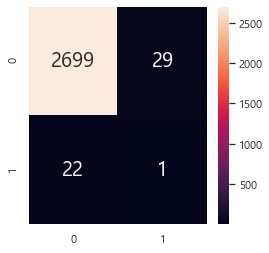

In [132]:
yhat=ocsvm.predict(X_test)

df_test['onesvm_anomaly']= yhat
df_test['onesvm_anomaly'] = df_test['onesvm_anomaly'].replace({1:0,-1:1})
cm=confusion_matrix(df_test['판정결과'], df_test['onesvm_anomaly'])
plt.rcParams["figure.figsize"] = (4,4)
sns.heatmap(cm, annot = True, fmt="d", annot_kws={"size": 20})

## 2.3. 준지도학습 훈련